In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash']

In [49]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [50]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([310156, 3]) torch.Size([310156])
torch.Size([38787, 3]) torch.Size([38787])
torch.Size([39068, 3]) torch.Size([39068])


In [51]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12108


In [52]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    #break

      0/ 200000: 26.4007
  10000/ 200000: 2.8850


KeyboardInterrupt: 

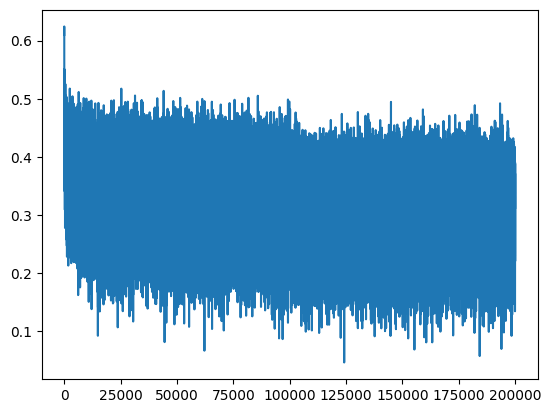

In [ ]:
plt.plot(lossi)

In [ ]:
# this decorator disables gradient tracking, so pytorch will not do any 
# book keeping in anticipation of backward pass as it will assume nothing 
# in this function requires gradients
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.972718596458435
val 2.0195250511169434


In [ ]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      #ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

tadriana.
mikalicey.
demil.
deep.
dine.
leigh.
del.
vedh.
ard aaleanniel.
grachrisshahleen.
ali.
krished.
pever.
bishar.
romit.
ell.
siah.
sijahirra.
den.
om pani.


#### Network currently is not properly initialized, as in the very first iteration we observe loss = 27

##### In training of neural nets, depending on loss function and problem setup, we usually have the rough idea for what loss value to expect at initialization

##### In this case, there are 28 char which can follow any char and at initialization we have no reason to believe that any char is more likely than others, so we expect that prob distribution that comes out initially is uniform distribution assigning nearly equal prob to all char i.e ~ 1/28 or (1/ vocab_size)

In [ ]:
-torch.tensor(1/28.0).log()

tensor(3.3322)

##### So right now at initialization, NN is creating prob distr which is non uniform in which some char are highly likely and some are not. So NN is very confidently wrong and that is what makes it record very high loss in the beginning

##### We want the logits to be roughly 0s or all nearly equal when the network is initialized

### Corrected inits of NN
##### We don't want to zero init the NN weights

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0 # as we want logits to be roughly 0s

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12108


### Issue with activations of hidden state: Many elements are 1 and -1, which means tanh is in saturated region

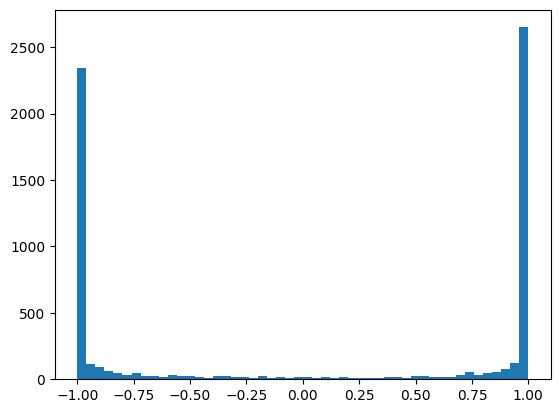

In [ ]:
h.shape
plt.hist(h.view(-1).tolist(), 50);

### hpreact, input to tanh takes of broad values

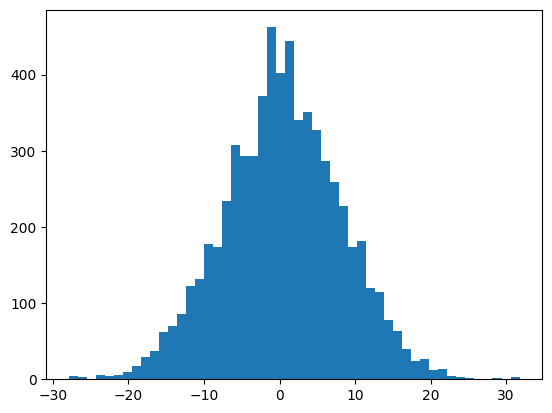

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

##### Above plots of activation h indcates issue with NN training: 
##### we are going to backprop through tanh and in backward pass tanh is out.grad * 1-t^2, so 1- 1^2 = 0 = 1-(-1)^2
##### Intutite looking at the graph of tanh around 1 1nd -1 it flattens out hence slope is near zero i.e gradient is 0 and training is slow. The gradient through tanh can only ever decrease and decrease amount is proportionate to how far it is in the flat region of tanh.
##### So if most tanh outputs are in flat region then gradient that are flowing through the network will just get destroyed at this layer.
##### Input values to tanh , i.e hpreact is too large and is creating distribution that is too saturated. We want it to be nearly zeros

### Lets look at how often it is in flat region

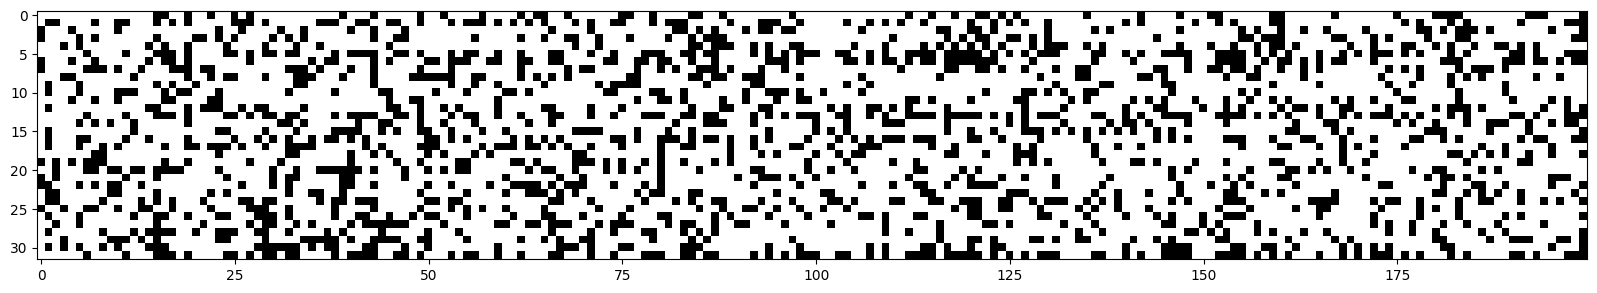

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

#### above we see 32 examples and 200 neurons and lot of it is white i.e in sturation region of tanh. We would be in trouble if for any one of these entier column was white which means it is a DEAD Neuron. 

#### This could be a tanh neuron where initialization of w and b could be such that no single example ever results in active part of tanh and they all result in tail part of tanh, This neuron will never learn.

#### This can also happen during optimization, e.g if you have too high learning rate (step size) then sometimes a neuron gets too much of gradient they get knocked out of data manifold and from then on no example ever activates this neuron and remains dead forever

#### Above is not the case with any neuron, so in this case it will learn but this approach is not optimal and not sometihng that is preferred especially initialization strategy used so far

#### This issue exists with other non lienearities too

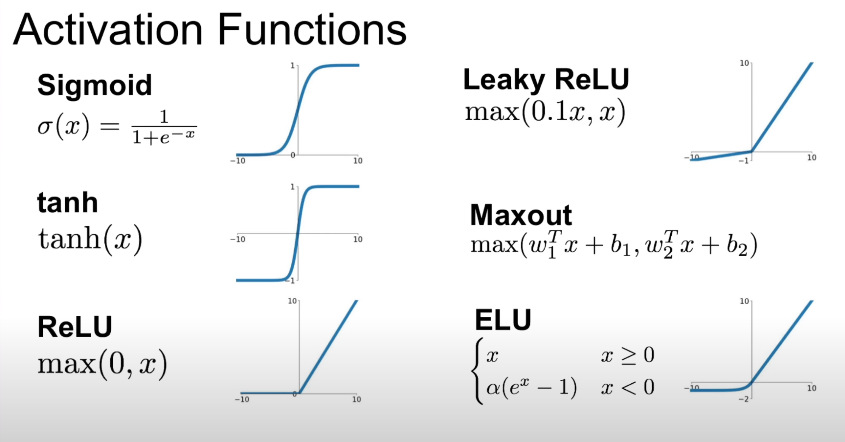

In [ ]:
from IPython.display import Image, display
display(Image(filename="activations.png", width=600, height=500))

#### After Initializing by weight squashing, below be can see that we have much better histograms as pre activations are between -1.5 to 1.5. (after first step of optimization)

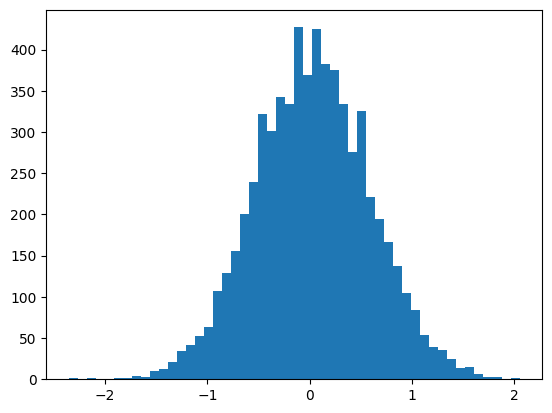

In [ ]:
plt.hist(hpreact.view(-1).tolist(), 50);

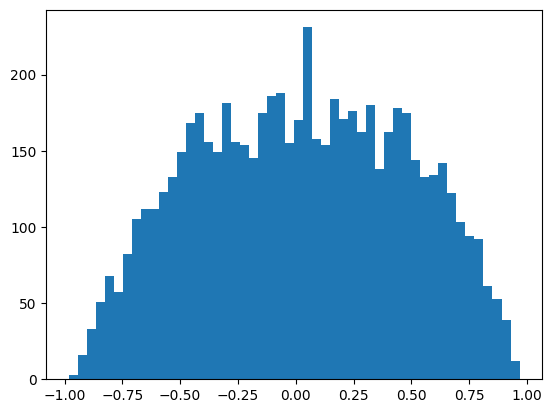

In [ ]:
plt.hist(h.view(-1).tolist(), 50);

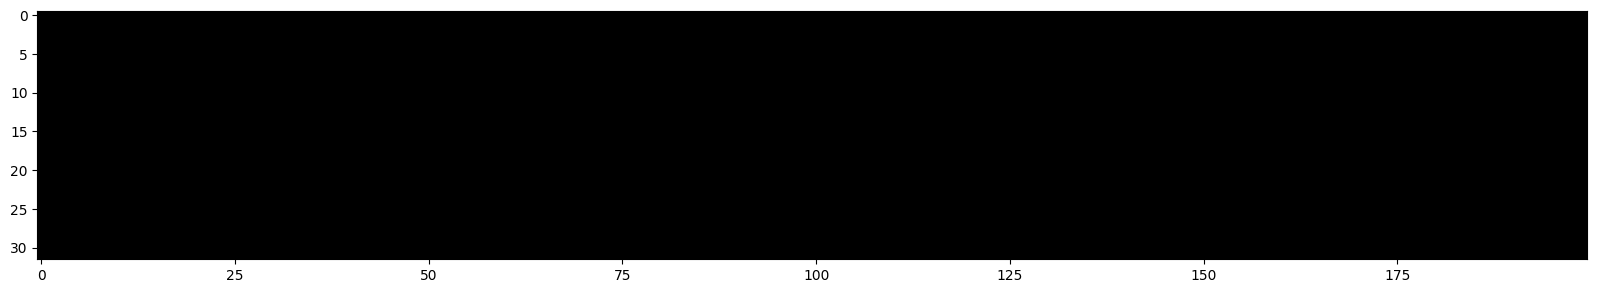

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Setting scales for initialization in principled manner

tensor(0.0070) tensor(1.0063)
tensor(0.0017) tensor(3.1874)


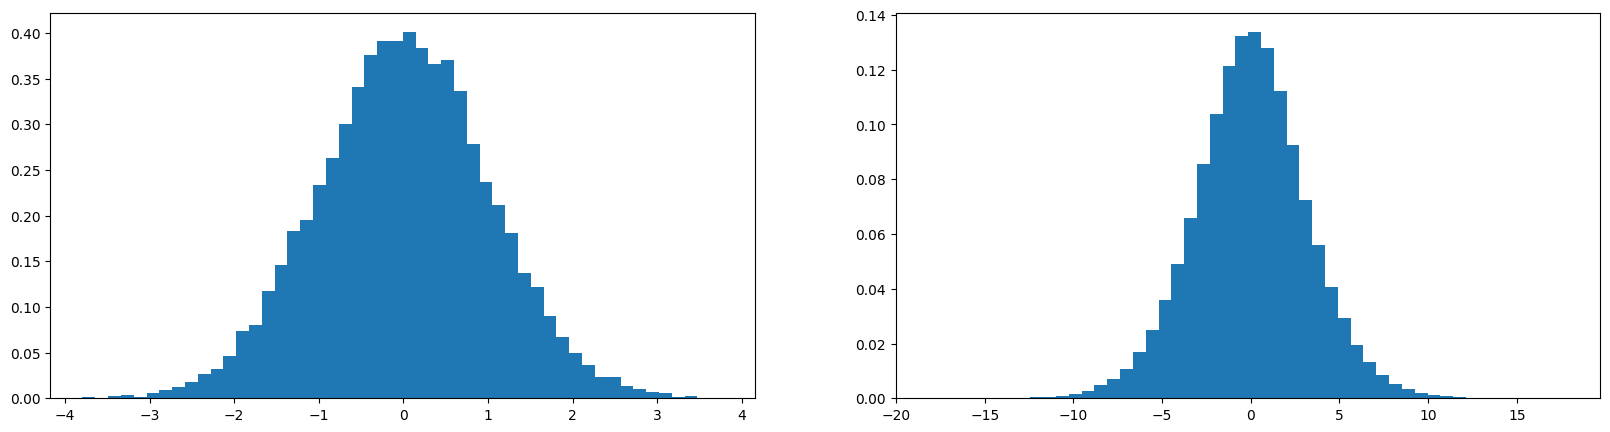

In [ ]:
# motivation
x = torch.randn(1000, 10) # gaussian
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

##### As we see std dev of Y is 3.1 whereas input std dev is 1, so it is exanding.
##### We donn't want this to be the case, we want most NN relatively similar activation i.e unit gaussian throughout the neural net
#### So the question is how do we scale the weights so that the distribution remains a nuit gaussian i.e to have std dev to be ~ 1

#### To maintain std dev of output as 1 we divide by sqrt of fan_in i.e number of input elements into neuron, just derived through variance calculation

tensor(-0.0079) tensor(0.9977)
tensor(-8.5481e-05) tensor(1.0077)


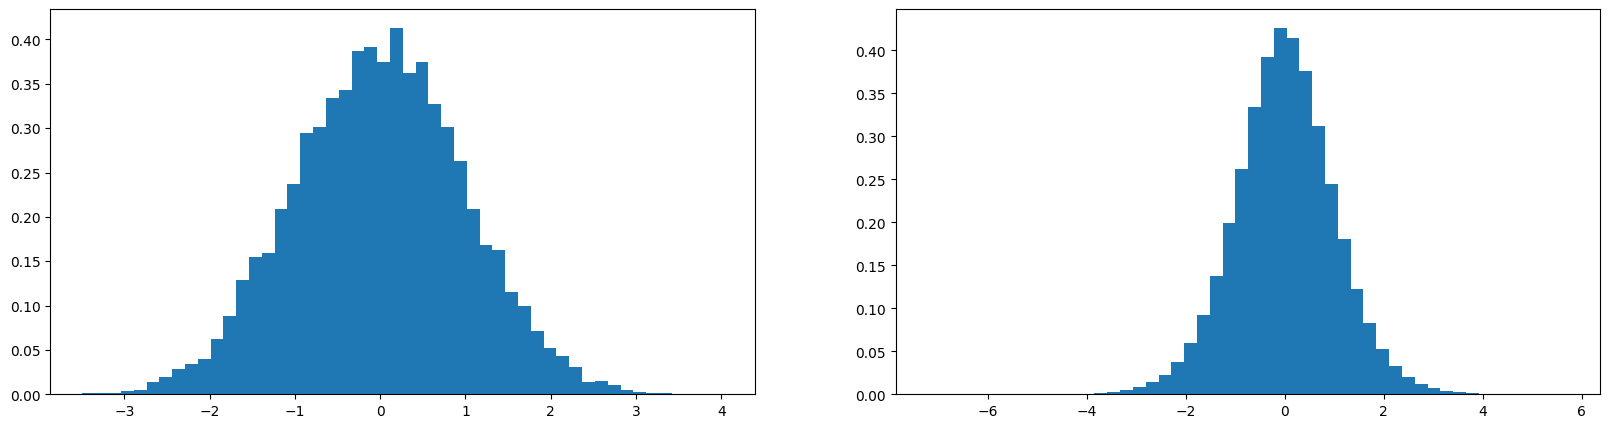

In [ ]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

### Kaiming Init
##### Multiply weights by sqrt (2/fan_in). constant 2 here is for relu non linearity and can be different for each non linearity. It is called 'gain'
##### They also studied backprop as gradients also need to be well behaved as they update the parameters
##### If we 'properly' initialized forward pass, backward pass is also approximately initialized upto a constant realted to number of hidden neurons in early and late layers. They find that this is not a choice that matters much

#### In pytorch we have kaiming_normal

#### Since kaiming paper was written several other techniques have come up which have made everything significantly more stable and well behaved and it has become less important to initialize these networks exactly right.

#### Better optimizers (adam, rmsprop etc), batch normalization, layer normalizatoin, residual connection etc etc to name a few

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)
# 5/3 is kaiming gain for tanh
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0 # as we want logits to be roughly 0s

parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12108


### Train with kaiming init, with 5/3 gain for tanh

In [ ]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.7699
  10000/ 200000: 2.3996
  20000/ 200000: 2.2110
  30000/ 200000: 2.0405
  40000/ 200000: 2.0940
  50000/ 200000: 2.5696
  60000/ 200000: 1.8320
  70000/ 200000: 2.2076
  80000/ 200000: 2.4448
  90000/ 200000: 1.6503
 100000/ 200000: 2.2421
 110000/ 200000: 2.1373
 120000/ 200000: 2.1493
 130000/ 200000: 1.8041
 140000/ 200000: 1.8823
 150000/ 200000: 2.3474
 160000/ 200000: 1.7685
 170000/ 200000: 2.0877
 180000/ 200000: 1.8935
 190000/ 200000: 1.5789


## Batch Normalization

#### We have hidden state hpreact, we don't want them to be too small as tanh doesn't do anything then and we also don't want them to be too large as tanh gets saturated

#### So we want them to be roughly coming from std gaussian i.e. 0 mean and 1 std dev at least at initialization
#### So what batchnorm says if you want them to be so, then just normalize them to be std gaussian

In [ ]:
hpreact.shape , hpreact.mean(0, keepdim=True).shape, hpreact.std(0, keepdim=True).shape

(torch.Size([32, 200]), torch.Size([1, 200]), torch.Size([1, 200]))

### Neural Layers as Matrix Multiplications
##### Setting things up for mental abstraction necessary for easy perusal of code before we dive deeper into complex and advanced concepts

In [ ]:
# Each neuron in a layer can be represented by:
#   - A weight vector `w ∈ ℝ^d` (d = input dimension)
#   - A bias scalar `b ∈ ℝ`
#   - An activation function `f(·)` (e.g., ReLU, tanh, etc.)
#
# For a batch of inputs:
#   - Let `X ∈ ℝ^{N × d}` be the input matrix (N = batch size)
#   - Let `W ∈ ℝ^{d × M}` be the weight matrix for M neurons
#   - Let `b ∈ ℝ^M` be the bias vector (one bias per neuron)
#
# The pre-activation and activation outputs are computed as:
#     preact = X @ W + b       # shape: [N × M]
#     output = f(preact)       # shape: [N × M]
#
# Interpretation of the `output` matrix:
#   - Each row corresponds to a single input's activation values across all neurons
#     → tells us how each input is represented by the layer
#
#   - Each column corresponds to a single neuron's activations across all input samples
#     → tells us how the neuron responds across the dataset

In [ ]:
# Normalize pre-activation outputs across the batch for each neuron of the layer.
#
# Setup used here:
# - Number of neurons: 200
# - Input dimension per sample: 30
# - Batch size: 32
#
# pre-activation for each neuron, hpreact = embcat @ W1 + b1,
# resulting in a tensor of shape [batch_size, num_neurons] → [32, 200].
#
# To standardize the pre-activations before applying the activation function (e.g., tanh), we:
#   1. Subtract the mean across the batch for each neuron:
#        hpreact = hpreact - hpreact.mean(0, keepdim=True)
#      This centers each neuron's output distribution to zero mean.
#
#   2. Divide by the standard deviation across the batch for each neuron:
#        hpreact = hpreact / hpreact.std(0, keepdim=True)
#      This scales each neuron's output distribution to unit variance.
#
# The result is that each neuron receives standardized inputs (zero mean, unit variance) across the batch,
# which helps stabilize and improve learning by avoiding saturation in the activation function.

#### Just normalizing using mean and std dev doesn't help much because we want pre acts to be roughly gaussian, but only at initialization, and not always forced to be gaussian  
#### We want to allow NN to move this around and this movement to be guided by backprop. This is achieved by scale and shift parameters bngain and bnbias
#### As bngain is init to ones and bnbias to zeros, at initialization input to neuron activatin func (i.e hpreact column) will be unit gaussian. During optimization we will be able to backprod bngain and bnbias and adjust them based on data guided by backprop

#### Compared to calculating normalizing constants for each layer, it is easier to sprinkle batch norm layers throughout the neural
#### It is common to append batch norm layer after linear layer (hpreact = embcat @ W1 + b1) or comvolution layer to control the scale of activations at avery point in the neural net
#### BN layers has it own bias(bnbais) so there is no need for bias in the layer before it as it is going to be subtracted out anyway, hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd),            generator=g)
# 5/3 is kaiming gain for tanh
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0 # as we want logits to be roughly 0s

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# BatchNorm buffers
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

12508


In [ ]:
# Train loop with batch norm
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0],-1)
    # Linear layer
    hpreact = embcat @ W1 #+ b1

    # BatchNorm layer
    # ---------------------------------------------------------------------------------
    # hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

    # running mean and std dev
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * ((hpreact - bnmeani) / bnstdi) + bnbias
    with torch.no_grad():
        # used during inference
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    # ---------------------------------------------------------------------------------

    # non linearity
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.5646
  10000/ 200000: 2.4172
  20000/ 200000: 2.3465
  30000/ 200000: 2.1075
  40000/ 200000: 2.1208
  50000/ 200000: 2.4473
  60000/ 200000: 1.9078
  70000/ 200000: 2.1649
  80000/ 200000: 2.4407
  90000/ 200000: 1.7409
 100000/ 200000: 2.4878
 110000/ 200000: 2.1877
 120000/ 200000: 2.0931
 130000/ 200000: 1.9328
 140000/ 200000: 2.0118
 150000/ 200000: 2.4242
 160000/ 200000: 1.9719
 170000/ 200000: 2.1867
 180000/ 200000: 1.9253
 190000/ 200000: 1.6271


### Consequences and side effects of using Batchnorm layers
#### Batch Normalization introduces important implications in both the forward and backward passes of a neural network. One of its key effects is that it mathematically couples all samples in a batch
#### In a typical neural network without BatchNorm, the output for a given input is deterministic — it depends solely on that input and the model parameters. However, when using BatchNorm, the mean and standard deviation used to normalize activations are computed across the batch.
#### This means that the output (e.g., pre-activations hpreact and logits) for a single data point depends not only on itself but also on the other examples in the batch.

### Regularization Effect
#### Because normalization statistics are batch-dependent, the same input can produce slightly different activations when placed in different batches with different peers
#### This results in jittering, output for the same input varies across training steps depending on what other samples are present in the batch. Instead of a sample producing a deterministic, isolated output, BatchNorm smears its output slightly by referencing other examples. It  blends the individual input into the broader batch context.
#### It behaves similarly to regularization, by preventing the model from overfitting too tightly to specific input examples


### At test time
#### Step after training which calculates mean and dev over whole train set (calibrate batch norm stats). But usually that is not what people do, and they are estimated in running manner during train time

In [ ]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0013954639434814
val 2.0347073078155518


## PyTorchifying Code

In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        # momentum : importance given to current batch's mean and std-dev
        # high for large batch sizes
        self.momentum = momentum
        self.eps = eps
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # gama initialized to ones and beta to zeros
        # 
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      #layer.weight *= 0.3
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46608


In [ ]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:    
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i>1000:
        break

      0/ 200000: 3.3021


## Visualizing histograms
### 1) histogram of forward pass activation Tanh
#### Calculating mean std-dev and %saturation, t.abs() > 0.97, of tanh layer. 
#### First layer is saturated and then everything stabilizes in further layers with std dev aorund 0.65 and saturaion around 5%. It is stabilizing because gain in linear layer is set to 5/3, essentially tanh values are spread out across -1 to 1 with very less saturation

layer 1 (      Tanh): mean -0.04, std 0.77, saturated: 23.75%
layer 3 (      Tanh): mean +0.03, std 0.69, saturated: 10.16%
layer 5 (      Tanh): mean +0.01, std 0.67, saturated: 6.66%
layer 7 (      Tanh): mean +0.01, std 0.65, saturated: 5.25%
layer 9 (      Tanh): mean -0.01, std 0.65, saturated: 5.34%


Text(0.5, 1.0, 'activation distribution')

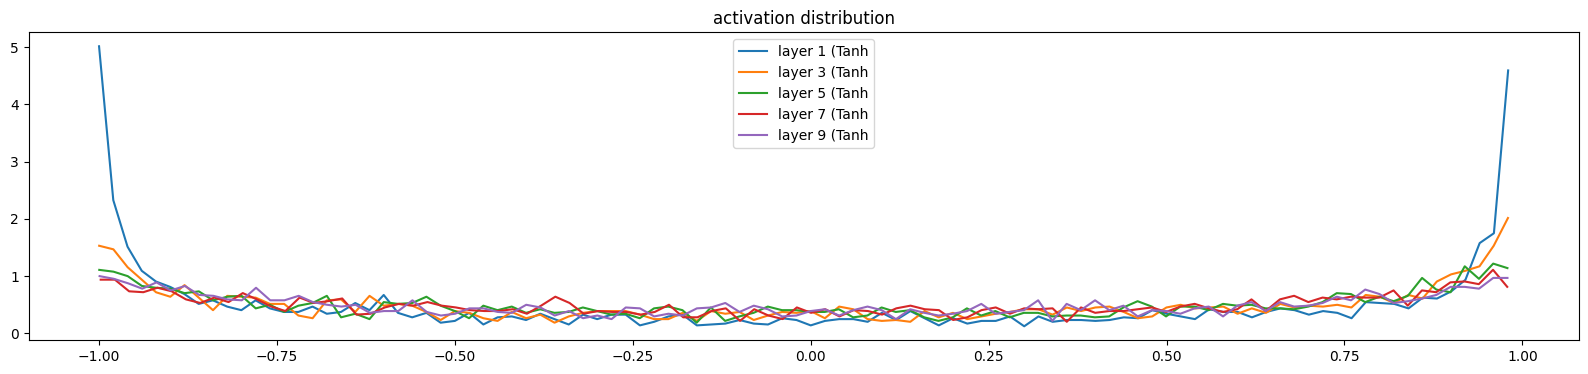

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

### Not using gain in linear layer 
#### Leads to unstabilized layers. Std dev and saturation is shirnking. Frist layer is decent but further layers are shinking down to 0
#### When we have just stack of only linear layers then initializing weights with randn() scaled by sqrt(fan_in) would have conserved std-dev of 1
#### But because be have tanh layers interspersed in there which is a squashing function, so it takes the distribution and slightly squashes it. So as we go deeper in NN some gain is necessary to keep expanding it to fight this squashing
#### 5/3 is good gain for stack of linear layer with tanh, as pointed out in kaiming init, anything too large leads to aturation of tanh activation values

layer 1 (      Tanh): mean -0.03, std 0.64, saturated: 4.66%
layer 3 (      Tanh): mean +0.02, std 0.49, saturated: 0.09%
layer 5 (      Tanh): mean +0.01, std 0.41, saturated: 0.00%
layer 7 (      Tanh): mean +0.01, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.00, std 0.31, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

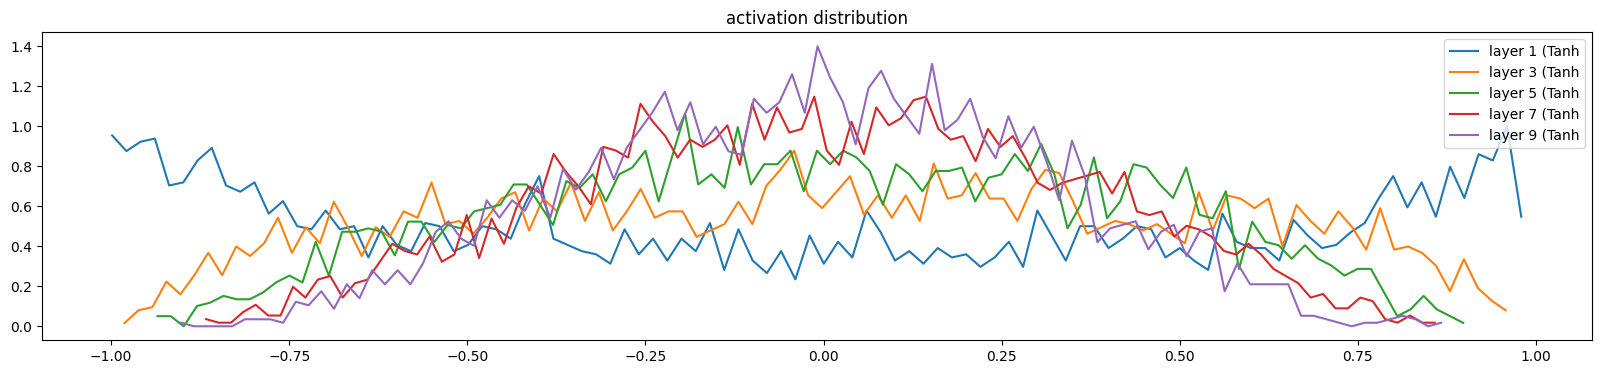

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('activation distribution')

### 2) Histogram of gradients
#### With use of gain, all the layers have roughly same gradient distribution, they are not shrinking or exploding

layer 1 (      Tanh): mean -0.000008, std 3.801411e-04
layer 3 (      Tanh): mean -0.000002, std 3.732448e-04
layer 5 (      Tanh): mean +0.000003, std 3.575446e-04
layer 7 (      Tanh): mean -0.000006, std 3.355822e-04
layer 9 (      Tanh): mean +0.000001, std 3.142416e-04


Text(0.5, 1.0, 'gradient distribution')

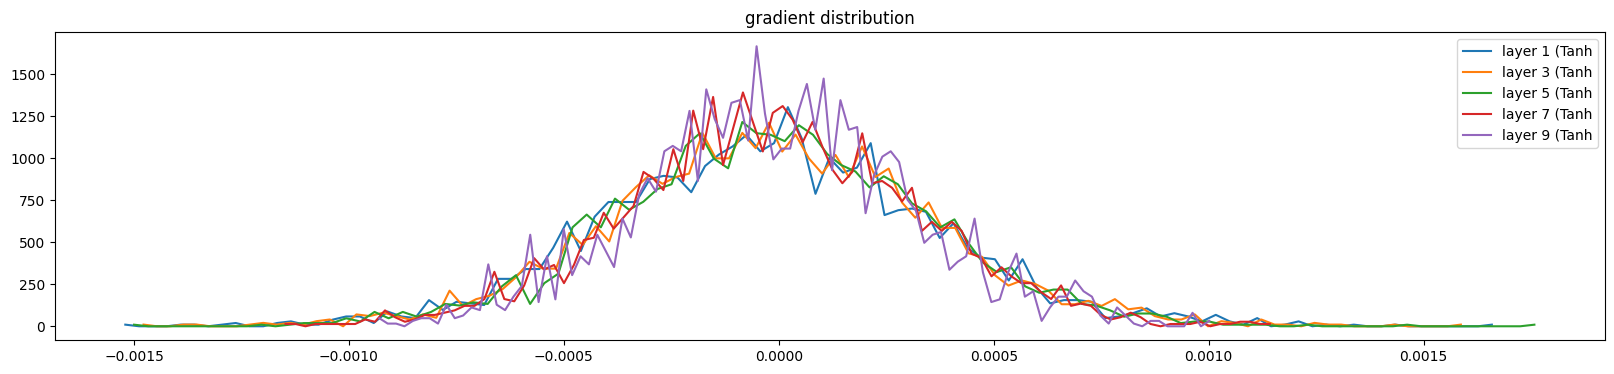

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

#### Without use of gain or with non appropriate values, gradient distribution is not well behaved
#### E.g. for small values like 0.3 gradient distribution expands as we go deeper into NN

layer 1 (      Tanh): mean -0.000000, std 2.362895e-06
layer 3 (      Tanh): mean -0.000000, std 7.873624e-06
layer 5 (      Tanh): mean +0.000000, std 2.699985e-05
layer 7 (      Tanh): mean -0.000002, std 9.215071e-05
layer 9 (      Tanh): mean +0.000001, std 3.141953e-04


Text(0.5, 1.0, 'gradient distribution')

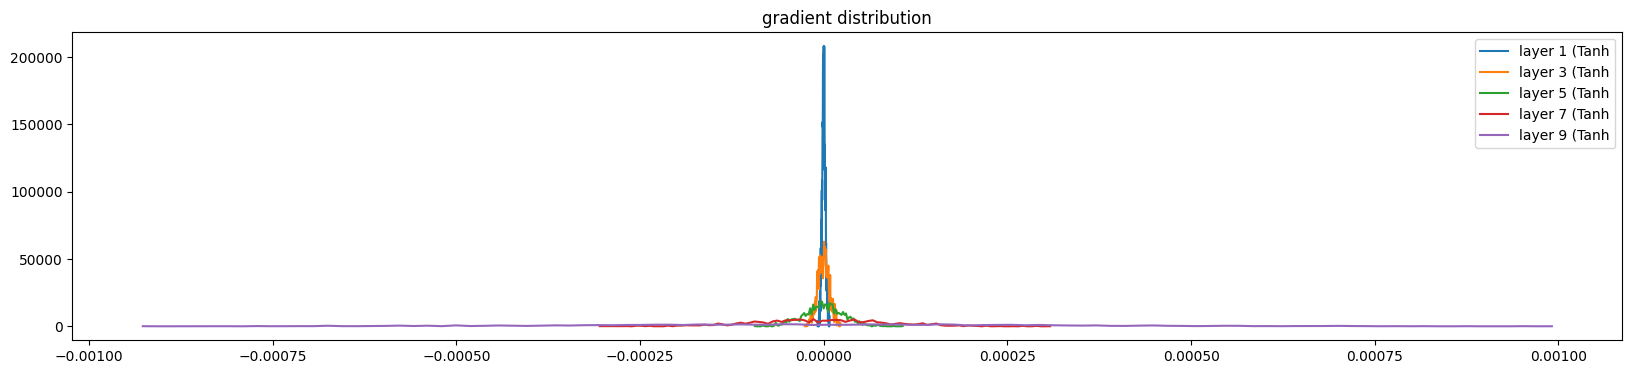

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

### 3) parameter(weights) gradient distribution (w.grad = out.grad * local-gradient)
#### Even with using gain, even though out.grad distribution is well behaved, weigths grad distribution dpesn't behave well
#### We observe that at init, last layer gradient sta dev is 10x larger compared to other layers, so it would train 10x faster tha other layers, which fixes itself as the training progress (as shows by karpathy in lecture at 1:39:11 ,akemore part 3) and we see the distribtion shrink somewhat and take smaller reasonable values
#### We calcuate grad:weight-value ratio, becasue if grad is too large compared to weight value then we are updating too fast
#### grad:weight-value is not that informative because what matters is update : weight-value

weight   (28, 10) | mean +0.000008 | std 1.199944e-03 | grad:data ratio 1.172075e-03
weight  (30, 100) | mean -0.000001 | std 1.229621e-03 | grad:data ratio 4.006587e-03
weight (100, 100) | mean -0.000028 | std 1.028259e-03 | grad:data ratio 6.178970e-03
weight (100, 100) | mean -0.000008 | std 9.357411e-04 | grad:data ratio 5.624531e-03
weight (100, 100) | mean +0.000033 | std 8.711768e-04 | grad:data ratio 5.230584e-03
weight (100, 100) | mean +0.000025 | std 7.896611e-04 | grad:data ratio 4.752107e-03
weight  (100, 28) | mean -0.000000 | std 2.199847e-02 | grad:data ratio 2.110050e+00


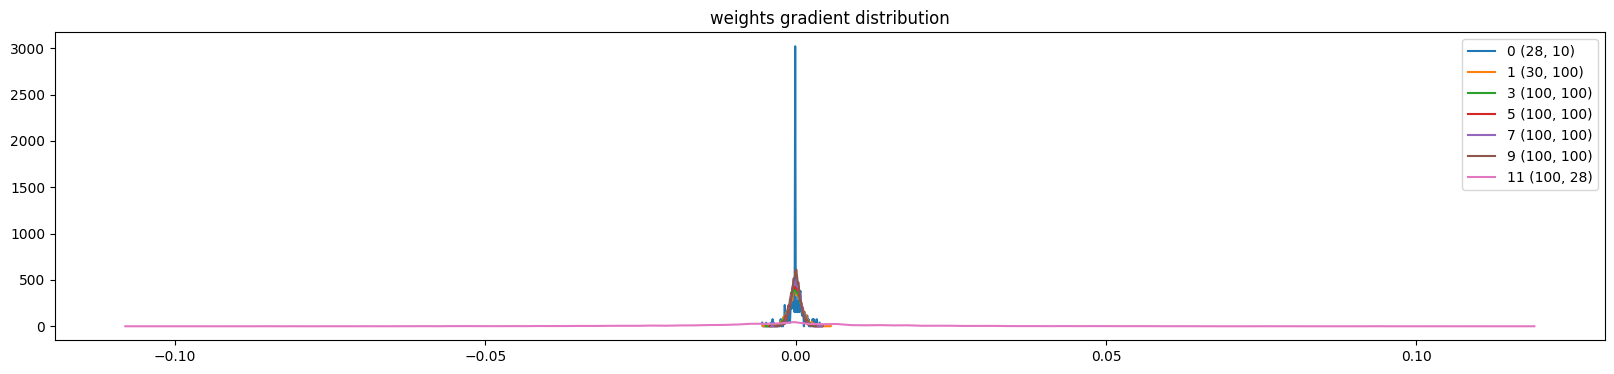

In [ ]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

### 4) weight-update std dev to weight-value std dev ratio log plot, after each iteration
#### How big are updates relative to values in these tensors

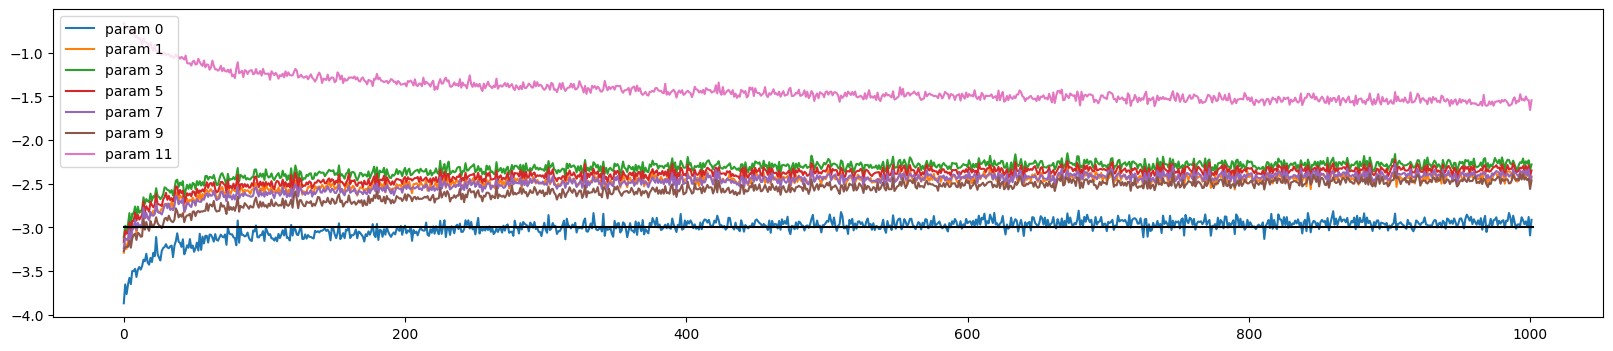

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

### Using BatchNorm Layer

In [58]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)

layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      #layer.weight *= 0.3
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47664


In [59]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:    
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    
    if i>1000:
        break

      0/ 200000: 3.3443


#### Using batchnorm layer makes network less sensitive to gain value used, e.g for 0.2 everything except update to weight ratio stays favorable, so we don't get absolute flexibility but it is much more robust. 
#### We may have to retune our learning rate if we are considerably changing the scale of activation that are coming into batchnorm

layer 2 (      Tanh): mean +0.01, std 0.63, saturated: 3.47%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.53%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.00%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.12%


Text(0.5, 1.0, 'activation distribution')

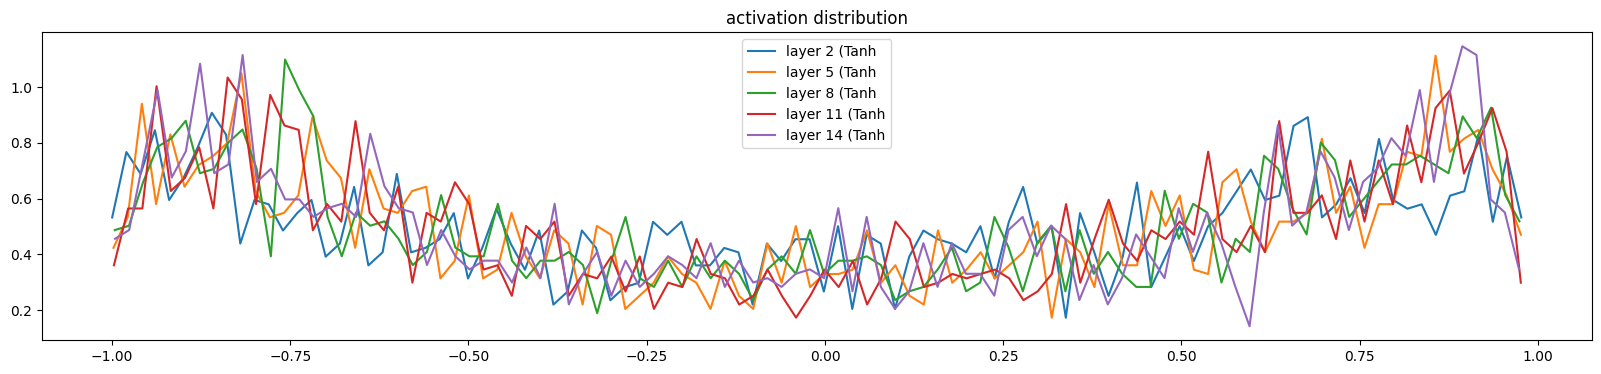

In [60]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')

plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 3.799904e-03
layer 5 (      Tanh): mean +0.000000, std 3.237221e-03
layer 8 (      Tanh): mean +0.000000, std 3.119117e-03
layer 11 (      Tanh): mean +0.000000, std 2.965768e-03
layer 14 (      Tanh): mean -0.000000, std 2.922401e-03


Text(0.5, 1.0, 'gradient distribution')

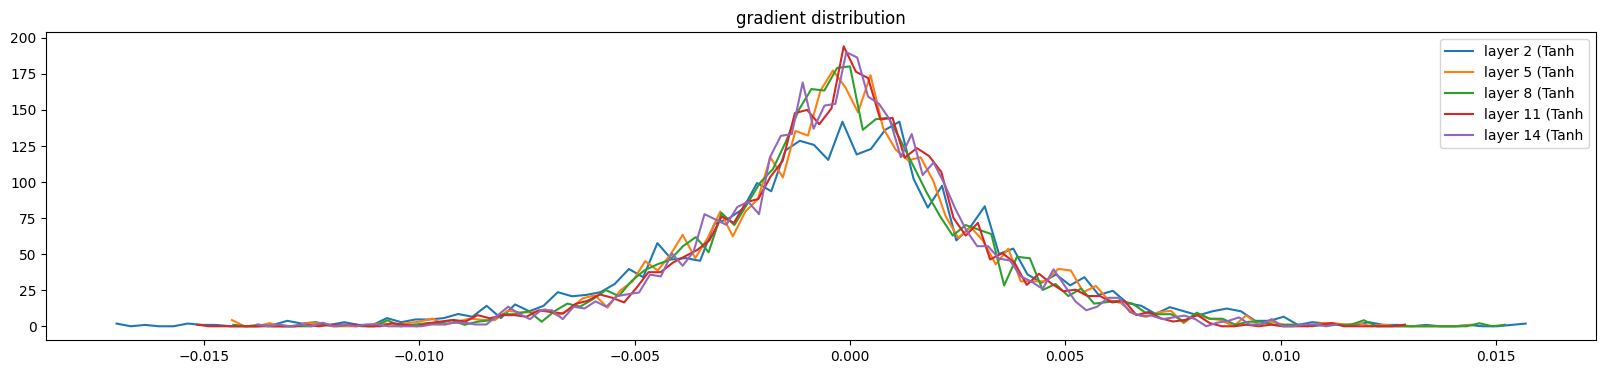

In [61]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (28, 10) | mean -0.000000 | std 1.043844e-02 | grad:data ratio 1.019309e-02
weight  (30, 100) | mean -0.000057 | std 8.189497e-03 | grad:data ratio 2.660239e-02
weight (100, 100) | mean -0.000048 | std 7.007043e-03 | grad:data ratio 4.177261e-02
weight (100, 100) | mean -0.000016 | std 6.339870e-03 | grad:data ratio 3.786589e-02
weight (100, 100) | mean +0.000006 | std 5.799063e-03 | grad:data ratio 3.463385e-02
weight (100, 100) | mean -0.000076 | std 5.561806e-03 | grad:data ratio 3.331428e-02
weight  (100, 28) | mean -0.000059 | std 1.099824e-02 | grad:data ratio 6.381047e-02


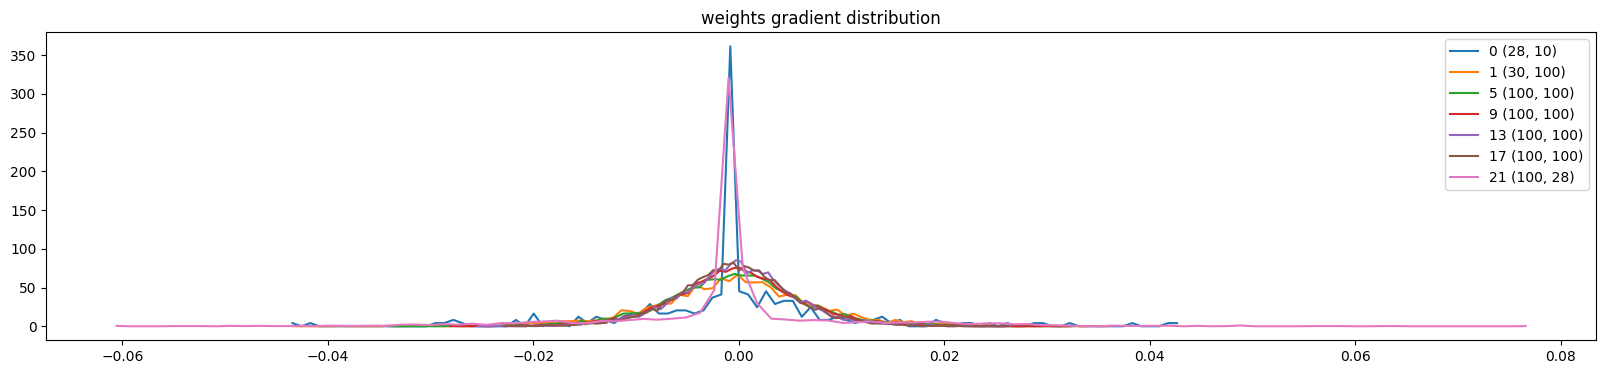

In [62]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

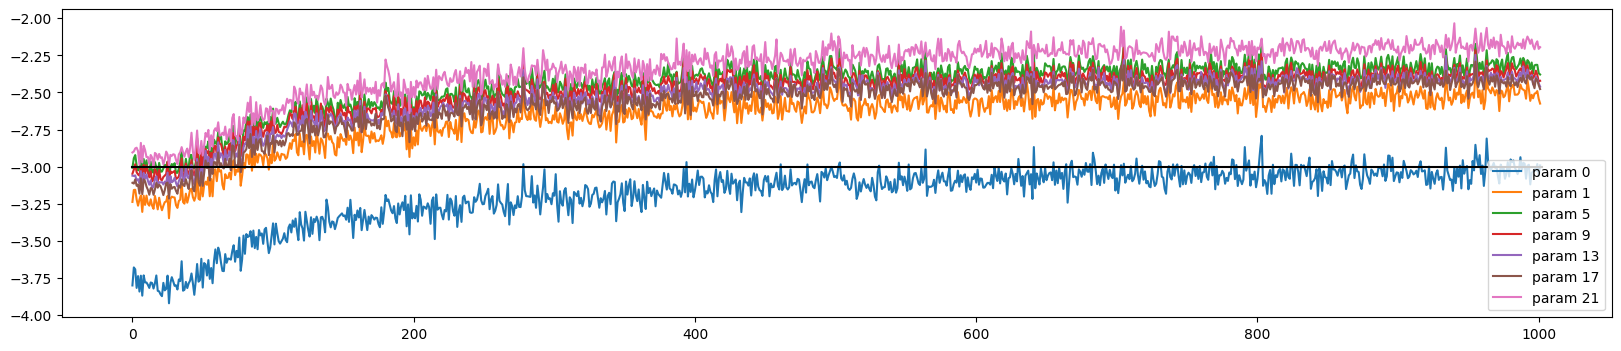

In [64]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);